In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## **Data Preparation**

In [91]:
data = pd.read_csv("train.csv")
data.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [92]:
data.shape

(1000, 12)

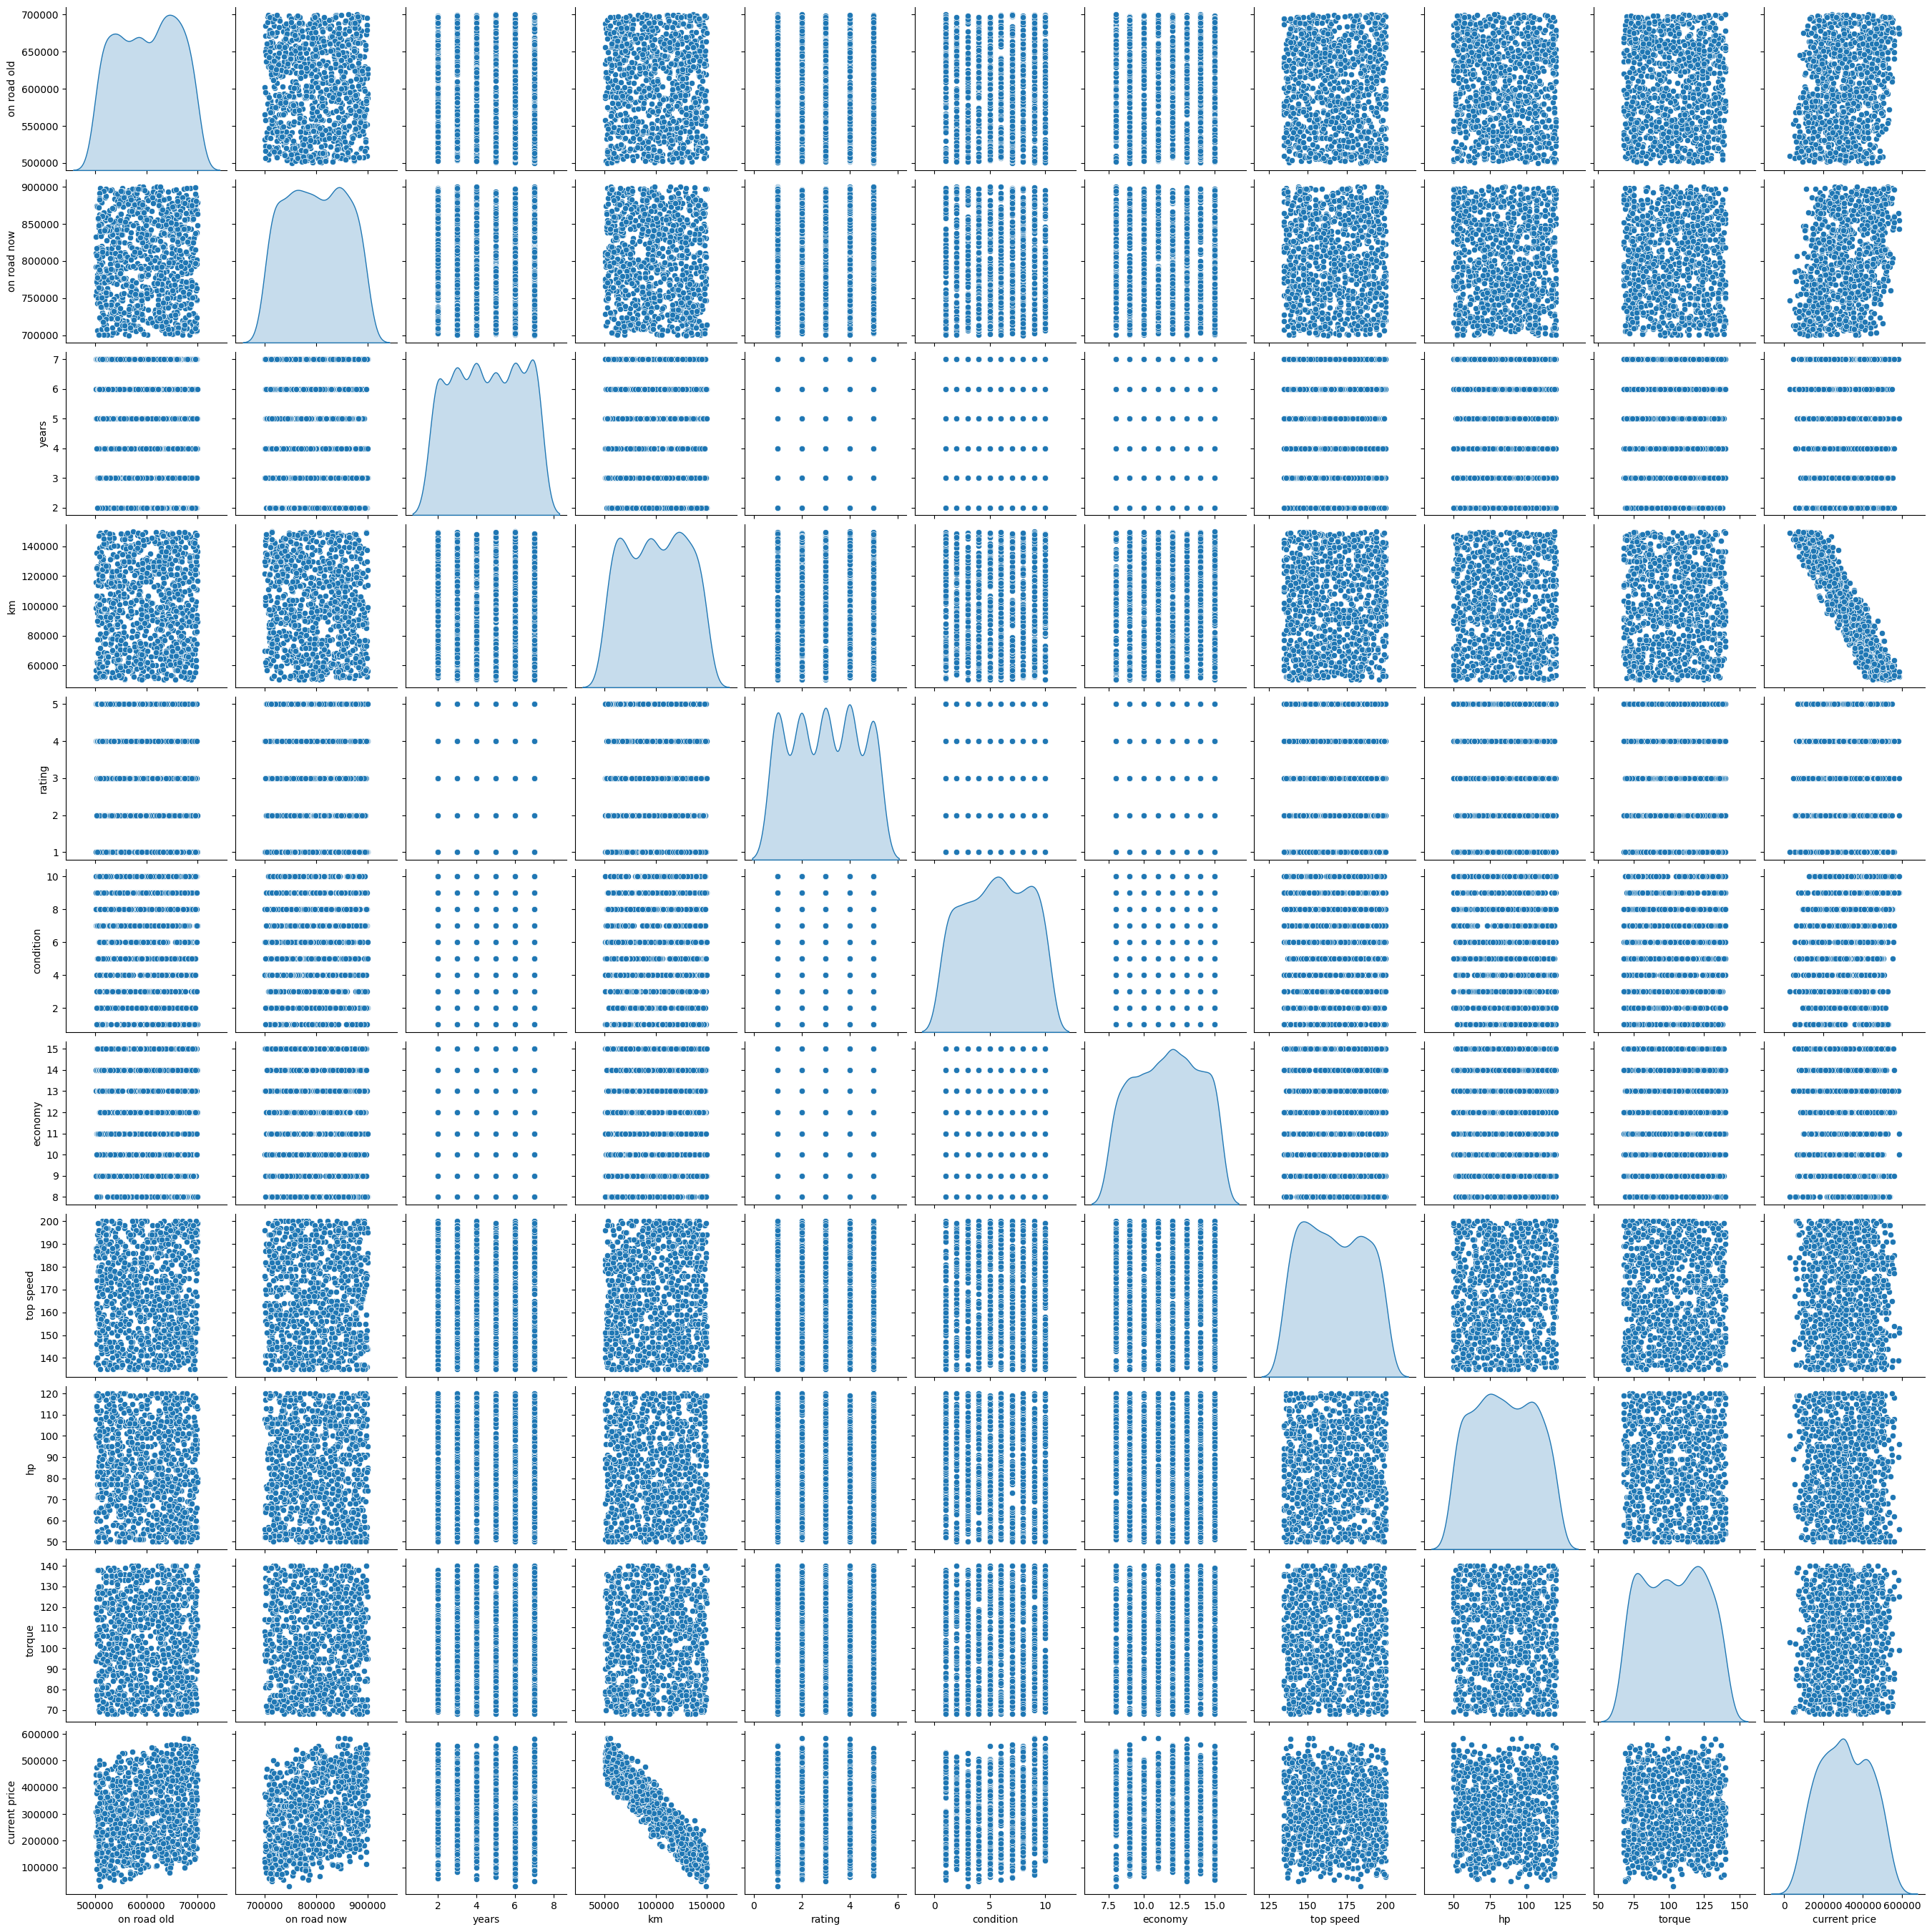

In [93]:
sns.pairplot(data[['on road old', 'on road now', 'years', 'km', 'rating', 'condition',
             'economy', 'top speed', 'hp', 'torque', 'current price']], diag_kind='kde')

In [94]:
tensor_data = tf.constant(data)
tensor_data = tf.cast(tensor_data, tf.float32)

In [95]:
tensor_data = tf.random.shuffle(tensor_data)

In [96]:
x = tensor_data[:, 1:-1]
x

<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[6.38236e+05, 7.93819e+05, 3.00000e+00, ..., 1.38000e+02,
        1.12000e+02, 1.07000e+02],
       [6.30489e+05, 7.17182e+05, 5.00000e+00, ..., 1.91000e+02,
        1.01000e+02, 9.40000e+01],
       [5.11480e+05, 7.07187e+05, 7.00000e+00, ..., 1.45000e+02,
        7.50000e+01, 1.28000e+02],
       ...,
       [5.46807e+05, 8.06720e+05, 6.00000e+00, ..., 1.77000e+02,
        8.30000e+01, 8.10000e+01],
       [5.88774e+05, 7.56503e+05, 5.00000e+00, ..., 1.97000e+02,
        1.15000e+02, 7.00000e+01],
       [5.57635e+05, 7.98449e+05, 3.00000e+00, ..., 1.81000e+02,
        1.15000e+02, 7.80000e+01]], dtype=float32)>

In [97]:
y = tensor_data[:, -1]
y

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([509506.5, 317119. , 178180.5, 420403. , 340720. , 457581. ,
       316652. , 327454.5, 137169.5, 328698. , 448106.5, 349780. ,
       547746. , 297886. , 310987. , 172234.5, 501083.5, 456840.5,
       440044.5, 306745.5, 369571.5, 354900. ,  46920.5, 252549.5,
       459095. , 307770.5, 394208.5, 292308.5, 239214. , 392097.5,
       376375. , 399055.5, 408860.5, 505336.5, 400444.5, 294378.5,
       229749.5, 208573.5, 180912. , 299129.5, 470890.5, 186308. ,
       492951. , 348000. , 295021. , 188186. , 320603. , 253530.5,
       375370.5, 179077. , 469084.5, 187050. , 479031. , 420102.5,
       181414.5, 429669. , 166571. , 418871.5, 116254.5, 324899.5,
       114860. , 212546.5, 335093.5, 348535. , 243565.5, 242709.5,
       433627. , 492753. , 286937.5, 516466. , 199798. , 385031. ,
       174352.5, 386141. , 377108.5, 158250.5, 209639. , 273761. ,
       144191.5, 240296.5, 282821.5, 526502.5, 385196. , 493994. ,
       296829

In [98]:
# To change the shape of y from (1000,) to (1000,1)
y = tf.expand_dims(y, axis=-1)
y

<tf.Tensor: shape=(1000, 1), dtype=float32, numpy=
array([[509506.5],
       [317119. ],
       [178180.5],
       [420403. ],
       [340720. ],
       [457581. ],
       [316652. ],
       [327454.5],
       [137169.5],
       [328698. ],
       [448106.5],
       [349780. ],
       [547746. ],
       [297886. ],
       [310987. ],
       [172234.5],
       [501083.5],
       [456840.5],
       [440044.5],
       [306745.5],
       [369571.5],
       [354900. ],
       [ 46920.5],
       [252549.5],
       [459095. ],
       [307770.5],
       [394208.5],
       [292308.5],
       [239214. ],
       [392097.5],
       [376375. ],
       [399055.5],
       [408860.5],
       [505336.5],
       [400444.5],
       [294378.5],
       [229749.5],
       [208573.5],
       [180912. ],
       [299129.5],
       [470890.5],
       [186308. ],
       [492951. ],
       [348000. ],
       [295021. ],
       [188186. ],
       [320603. ],
       [253530.5],
       [375370.5],
       [179077. ],

standardised x = (x - mean)/(standard deviation = sqrt(variance))

In [99]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 32

# Validate ratios
assert train_ratio + val_ratio + \
    test_ratio == 1.0, "Train, val, and test ratios must sum to 1."

# Convert tensors to numpy arrays for splitting
x_np = x.numpy()
y_np = y.numpy()


# Split the data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    x_np, y_np, test_size=(1 - train_ratio), random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(
    test_ratio / (val_ratio + test_ratio)), random_state=42)

# Apply normalization
normalizer = Normalization()
normalizer.adapt(x_train)
normalizer.adapt(x_val)
normalizer.adapt(x_test)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

print(train_dataset)

# Shuffle, batch, and prefetch
train_dataset = train_dataset.shuffle(buffer_size=len(
    x_train), reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=len(
    x_train), reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=len(
    x_train), reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>


In [100]:
for i in train_dataset:
    print(i)

(<tf.Tensor: shape=(32, 10), dtype=float32, numpy=
array([[6.42956e+05, 7.37175e+05, 6.00000e+00, 8.98160e+04, 1.00000e+00,
        5.00000e+00, 1.20000e+01, 1.70000e+02, 5.70000e+01, 7.20000e+01],
       [6.39975e+05, 8.60663e+05, 5.00000e+00, 6.01990e+04, 1.00000e+00,
        1.00000e+01, 1.20000e+01, 1.85000e+02, 1.18000e+02, 1.37000e+02],
       [6.31367e+05, 7.31363e+05, 4.00000e+00, 5.98060e+04, 2.00000e+00,
        2.00000e+00, 8.00000e+00, 1.56000e+02, 5.90000e+01, 1.26000e+02],
       [5.30951e+05, 7.41086e+05, 4.00000e+00, 1.16318e+05, 3.00000e+00,
        8.00000e+00, 1.50000e+01, 1.71000e+02, 1.06000e+02, 1.18000e+02],
       [6.33344e+05, 7.56063e+05, 5.00000e+00, 7.80250e+04, 1.00000e+00,
        9.00000e+00, 1.50000e+01, 1.71000e+02, 9.40000e+01, 1.32000e+02],
       [6.85935e+05, 7.84038e+05, 5.00000e+00, 1.11461e+05, 2.00000e+00,
        8.00000e+00, 1.20000e+01, 1.42000e+02, 7.30000e+01, 1.14000e+02],
       [6.22089e+05, 8.15583e+05, 7.00000e+00, 1.13889e+05, 5.00000

In [101]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(10,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1408      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
model.compile(optimizer=Adam(learning_rate=0.1),
              loss=MeanAbsoluteError(),
              metrics=RootMeanSquaredError())

In [103]:
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100


25/25 [==============================] - 2s 16ms/step - loss: 495735.8125 - root_mean_squared_error: 1550146.2500 - val_loss: 189926.8125 - val_root_mean_squared_error: 212811.6094
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 105027.9297 - root_mean_squared_error: 131207.7969 - val_loss: 58573.5117 - val_root_mean_squared_error: 71864.3828
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 38410.1133 - root_mean_squared_error: 50197.4102 - val_loss: 18448.9258 - val_root_mean_squared_error: 23042.1660
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 38888.8164 - root_mean_squared_error: 50827.1328 - val_loss: 18217.6172 - val_root_mean_squared_error: 22033.5742
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 41051.2695 - root_mean_squared_error: 54374.0625 - val_loss: 73813.1094 - val_root_mean_squared_error: 77055.2422
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - lo

In [104]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [118]:
def plot_performance(history):
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('model performance')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

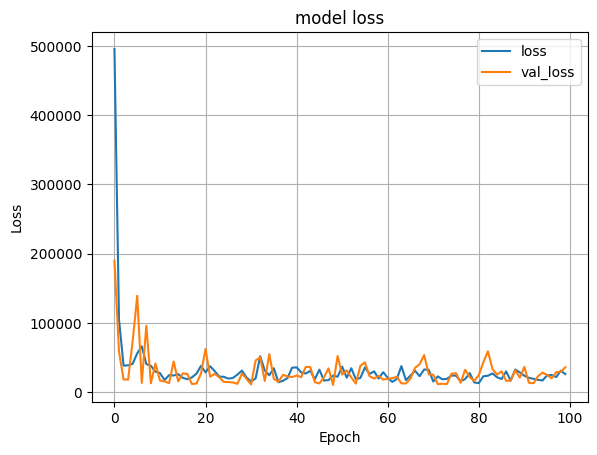

In [106]:
plot_loss(history)

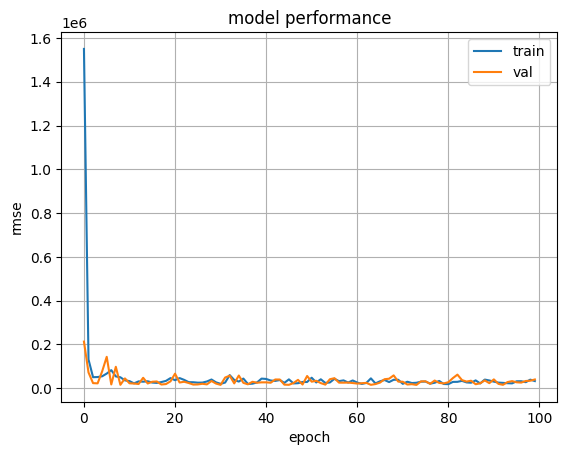

In [119]:
plot_performance(history)

## **Model Evaluation and Testing**

In [108]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 34473.8594 - root_mean_squared_error: 37301.8164


[34473.859375, 37301.81640625]

In [109]:
x_test.shape

(100, 10)

In [110]:
model.predict(tf.expand_dims(x_test[0], axis=0))

1/1 [==============================] - 0s 166ms/step


array([[390320.97]], dtype=float32)

In [111]:
y_test[0]

array([392864.], dtype=float32)

In [112]:
y_true = list(y_test[:, 0])

In [113]:
y_pred = list(model.predict(x_test)[:, 0])
y_pred

4/4 [==============================] - 0s 2ms/step


[390320.97,
 489681.78,
 134770.81,
 147073.67,
 138966.7,
 422206.66,
 468288.22,
 254241.25,
 112652.125,
 129403.04,
 428256.44,
 208868.69,
 322997.88,
 272897.84,
 434748.3,
 350958.75,
 472719.97,
 317955.22,
 147163.86,
 178625.02,
 318192.5,
 345702.62,
 328759.3,
 326308.03,
 541885.75,
 70144.93,
 536095.94,
 161644.7,
 313770.22,
 504338.66,
 497223.84,
 163669.33,
 394849.56,
 228932.78,
 321334.25,
 329531.53,
 476085.06,
 447069.97,
 237018.92,
 289935.9,
 462065.97,
 220292.23,
 253703.14,
 216487.28,
 383602.72,
 134102.45,
 397020.25,
 374260.72,
 414339.78,
 145458.1,
 253688.45,
 259333.61,
 115775.27,
 201453.69,
 303746.97,
 192782.44,
 338245.12,
 364111.53,
 322946.4,
 355937.97,
 99755.39,
 397050.9,
 517954.8,
 104459.97,
 630218.94,
 312926.6,
 592488.7,
 442401.25,
 390447.7,
 440010.75,
 292162.75,
 510766.72,
 313266.97,
 505405.97,
 325173.06,
 376392.16,
 351196.44,
 187442.33,
 416501.1,
 154819.8,
 168526.73,
 332116.38,
 223134.39,
 349128.97,
 168635.

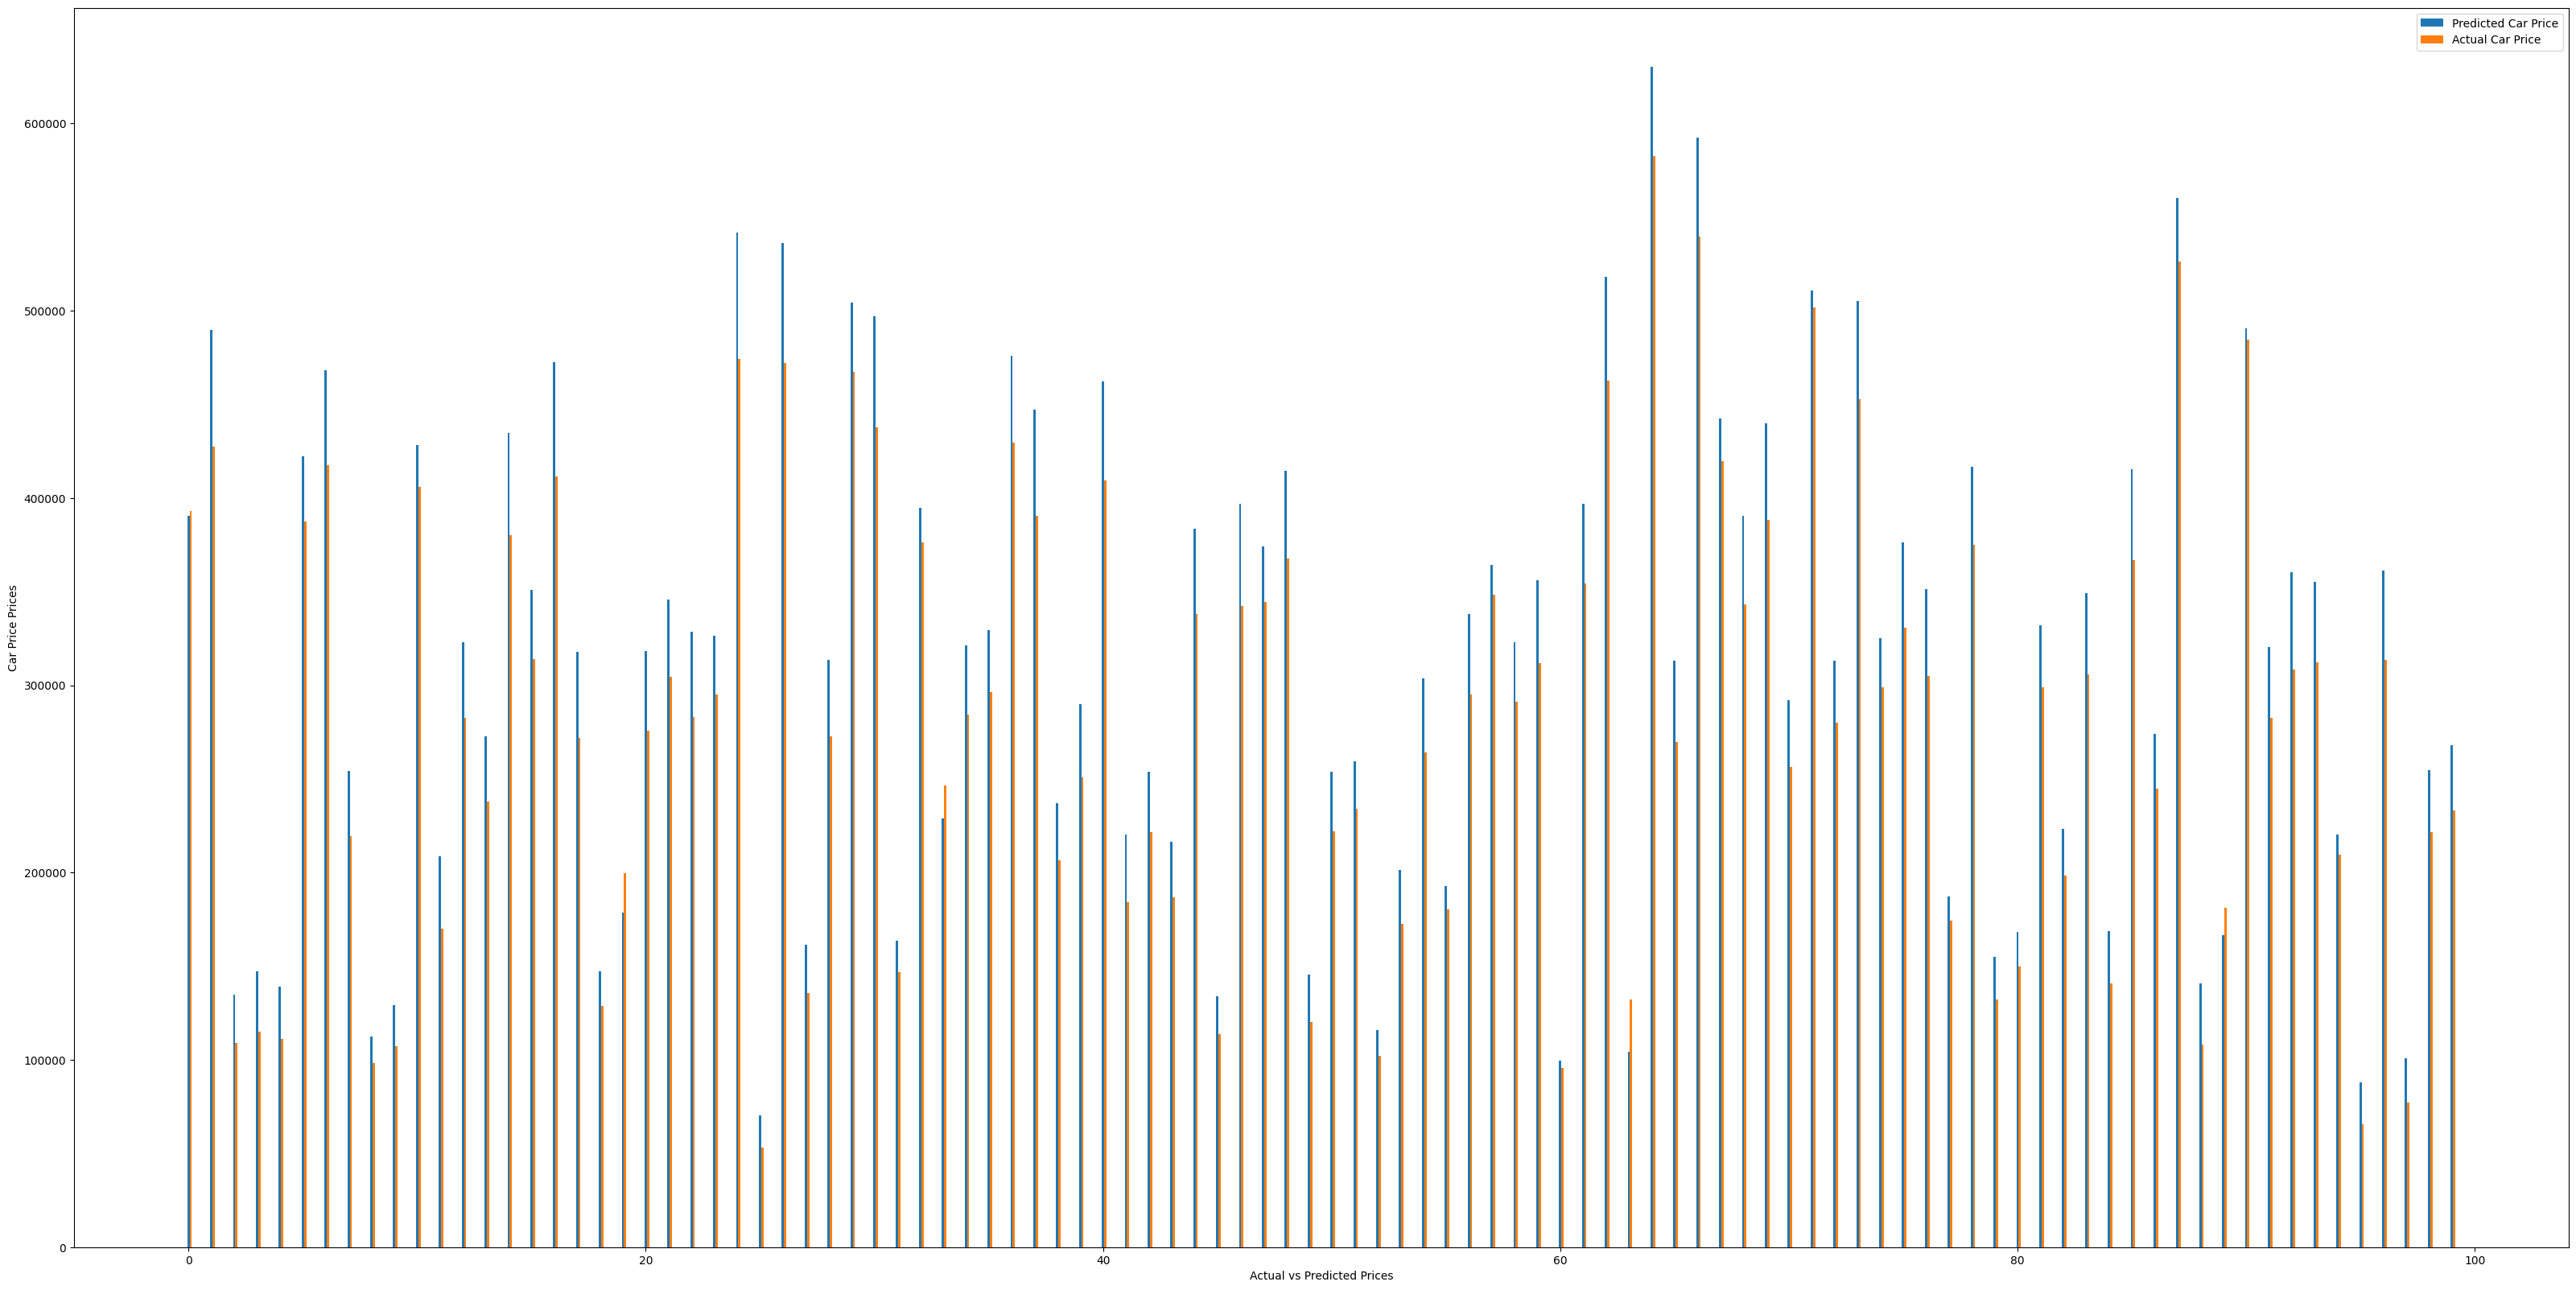

In [114]:
ind = np.arange(100)
plt.figure(figsize=(40, 20))

width = 0.1

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')
plt.legend(loc='best')
plt.show()

In [115]:
mae = mean_absolute_error(y_test, y_pred)
mae

34473.863

In [116]:
mse = mean_squared_error(y_test, y_pred)
mse

1391425400.0

In [117]:
r2 = r2_score(y_test, y_pred)
r2

0.9050443696883099